# Quantifying Data Distortion

Teng-Jui Lin

- Created: 2023-05-28
- Edited: 2024-10-03

In [1]:
from bar_constants import *
from bar_data import *
import bar_util as util
set_save_fig_rc()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Data Distortion Metrics

### Utility functions

In [2]:
def label_stats(ax, pvalue, gamma, x=0.5, y=0.85, color='k', two_sample=True):
    line_y_offset = 0.03
    line_x_offset = 0.15
    if pvalue < 0.001:
        ax.text(
            x, 
            y,
            '$\it{P}$ = ' + f'{pvalue:.1e}' + '\n$\gamma$ = ' + f'{gamma:.2}',
            ha='center',
            transform=ax.transAxes,
            color=color,
        )
    else:
        ax.text(
            x, 
            y,
            '$\it{P}$ = ' + f'{pvalue:.2}' + '\n$\gamma$ = ' + f'{gamma:.2}',
            ha='center',
            transform=ax.transAxes,
            color=color,
        )
    if two_sample:
        ax.axhline(
            (y - line_y_offset) * ax.get_ylim()[1],
            x - line_x_offset, 
            x + line_x_offset,
            color=color,
            lw=1,
        )

### 4 Data distortion metrics for general view

n = 747 Zeroing
n = 387 Log
(1134, 18)
L_12 zeroing 2.6891354854487606
L_12 log 0.2388815767308699
log L_12 zeroing 0.42687767977337776
log L_12 log -0.6640937273163542
Visualization excluded outlier 2/1134 = 0.001763668430335097
n = 747 Zeroing
n = 387 Log
(1134, 18)
F_12 zeroing 1.2553605152774183
F_12 log 0.22600754243272225
log F_12 zeroing 0.0987182254203666
log F_12 log -0.6747114207668304
Visualization excluded outlier 7/1134 = 0.006172839506172839
log RCVQ
n = 732 Zeroing
n = 390 Log
(1122, 10)
Visualization excluded outlier 8/1122 = 0.0071301247771836

log RCVM
n = 732 Zeroing
n = 390 Log
(1122, 10)
Visualization excluded outlier 5/1122 = 0.004456327985739751



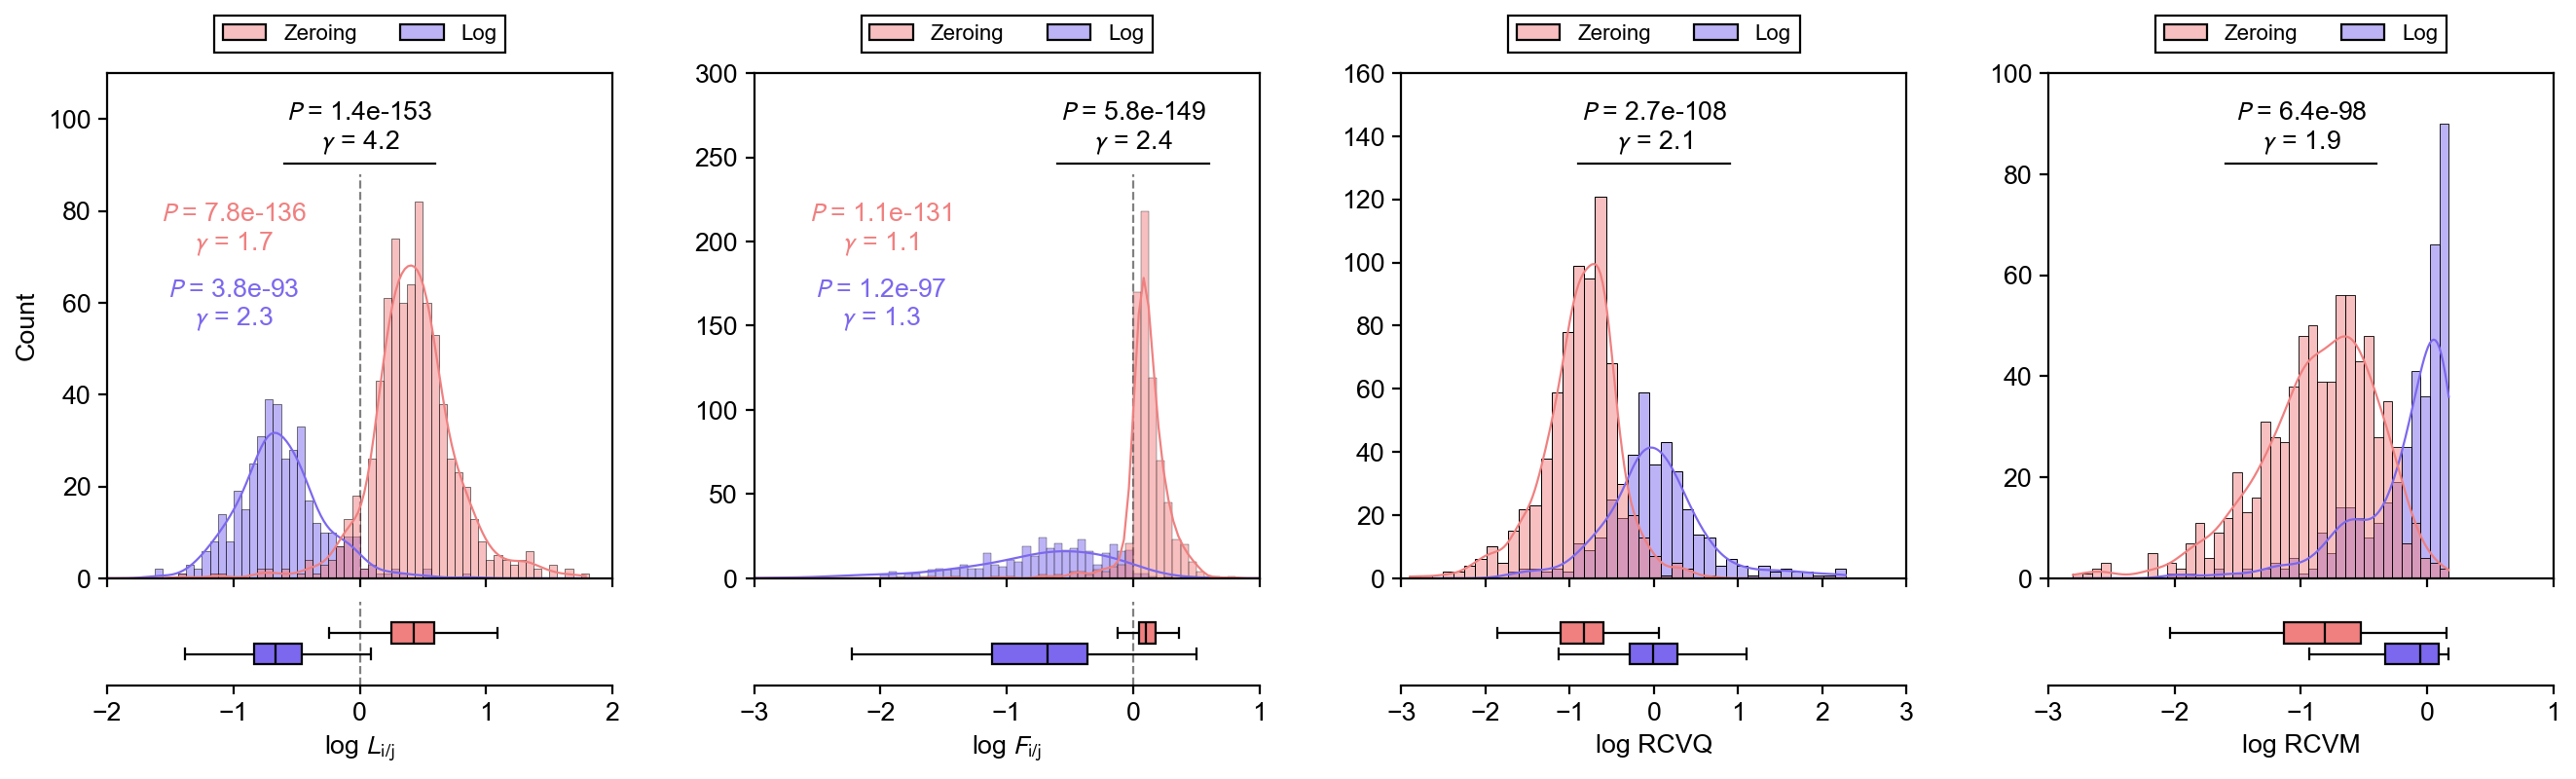

In [3]:
bins = np.arange(-2, 2 + 0.0625, 0.0625)

fig, axs = plt.subplots(2, 4, figsize=(17, 5), height_ratios=[6, 1], sharex='col')
ax_box_rel = axs[1, 0]
ax_hist_rel = axs[0, 0]
ax_box_abs = axs[1, 1]
ax_hist_abs = axs[0, 1]

## subplot 1
property = 'log L_12'
# define visualization domain
xmin = -2
xmax = 2
# eliminate bar-level bias by groupby graphs
plot_df = L_df.groupby(L_df.index).median()
# tag on text properties
plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Mistake', 'Measurand Level I']])
# eliminate graph-level bias by groupby physical quantities
plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.reset_index()
# define zero and log conditions
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')

# print info
print(f"n = {sum(zero_cond)} Zeroing")
print(f"n = {sum(log_cond)} Log")
print(plot_df.shape)
print('L_12 zeroing', plot_df.loc[zero_cond, 'L_12'].median())
print('L_12 log', plot_df.loc[log_cond, 'L_12'].median())
print('log L_12 zeroing', plot_df.loc[zero_cond, property].median())
print('log L_12 log', plot_df.loc[log_cond, property].median())

excluded_df = plot_df[(
    ((plot_df[property] > xmax) | (plot_df[property] < xmin))
)]
print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")

# visualization
sns.boxplot(
    plot_df,
    x=property,
    hue='Mistake', 
    ax=ax_box_rel,
    width=0.5,
    legend=False,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
hist = sns.histplot(
    plot_df,
    x=property, 
    hue='Mistake', 
    kde=True,
    bins=bins,
    ax=ax_hist_rel,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
)
ax_box_rel.set_xlim(xmin, xmax)
ax_hist_rel.set_xlim(xmin, xmax)
ax_hist_rel.set_ylim(0, 110)

# configure legend
sns.move_legend(
    hist, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

# label two-sample stats
stat, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
label_stats(
    ax_hist_rel, 
    pvalue, 
    gamma,
)

# label one sample location
one_sample_zero_x = 0.25
one_sample_log_x = one_sample_zero_x
one_sample_zero_y = 0.65
one_sample_y_offset = 0.15
one_sample_log_y = one_sample_zero_y - one_sample_y_offset

# label one-sample stats (zero)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[zero_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    [0]
)
label_stats(
    ax_hist_rel, 
    pvalue, 
    gamma,
    x=one_sample_zero_x,
    y=one_sample_zero_y,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

# label one-sample stats (log)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[log_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[log_cond, property],
    [0]
)
label_stats(
    ax_hist_rel, 
    pvalue, 
    gamma,
    x=one_sample_log_x,
    y=one_sample_log_y,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

## subplot 2
property = 'log F_12'
# define visualization domain
xmin = -3
xmax = 1
# eliminate bar-level bias by groupby graphs
plot_df = util.keep_finite(L_df)
plot_df = plot_df[plot_df['x_1'] > plot_df['x_2']].groupby(plot_df[plot_df['x_1'] > plot_df['x_2']].index).median()
# tag on text properties
plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Mistake', 'Measurand Level I']])  
# eliminate graph-level bias by groupby physical quantities
plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
plot_df = plot_df.reset_index()
# define zero and log conditions
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')

# print info
print(f"n = {sum(zero_cond)} Zeroing")
print(f"n = {sum(log_cond)} Log")
print(plot_df.shape)
print('F_12 zeroing', plot_df.loc[zero_cond, 'F_12'].median())
print('F_12 log', plot_df.loc[log_cond, 'F_12'].median())
print('log F_12 zeroing', plot_df.loc[zero_cond, property].median())
print('log F_12 log', plot_df.loc[log_cond, property].median())

excluded_df = plot_df[(
    ((plot_df[property] > xmax) | (plot_df[property] < xmin))
)]
print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")

# visualization
sns.boxplot(
    plot_df,
    x=property,
    hue='Mistake', 
    ax=ax_box_abs,
    width=0.5,
    legend=False,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
hist = sns.histplot(
    plot_df,
    x=property, 
    hue='Mistake', 
    kde=True,
    bins=bins,
    ax=ax_hist_abs,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
)
ax_box_abs.set_xlim(xmin, xmax)
ax_hist_abs.set_xlim(xmin, xmax)
ax_hist_abs.set_ylim(0, 300)

# configure legend
sns.move_legend(
    hist, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

# label two-sample stats
stat, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
label_stats(
    ax_hist_abs, 
    pvalue, 
    gamma,
    x=0.75,
    y=0.85
)

# label one sample location
one_sample_zero_x = 0.25
one_sample_log_x = one_sample_zero_x
one_sample_zero_y = 0.65
one_sample_y_offset = 0.15
one_sample_log_y = one_sample_zero_y - one_sample_y_offset

# label one-sample stats (zero)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[zero_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    [0]
)
label_stats(
    ax_hist_abs, 
    pvalue, 
    gamma,
    x=one_sample_zero_x,
    y=one_sample_zero_y,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

# label one-sample stats (log)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[log_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[log_cond, property],
    [0]
)
label_stats(
    ax_hist_abs, 
    pvalue, 
    gamma,
    x=one_sample_log_x,
    y=one_sample_log_y,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

# common labels by row and col
for i in range(2):
    axs[0, i].set_box_aspect(1)
    axs[0, i].axvline(0, 0, 0.8, color='gray', lw=1, ls='--', zorder=0)
    
    axs[1, i].set_box_aspect(1/6)
    axs[1, i].axis()
    axs[1, i].spines['left'].set_linewidth(0)
    axs[1, i].spines['right'].set_linewidth(0)
    axs[1, i].spines['top'].set_linewidth(0)
    axs[1, i].tick_params(
        axis='y',
        which='both',
        left=False,
    )
    axs[1, i].axvline(0, 0, 1, color='gray', lw=1, ls='--', zorder=0)


# subplot 3, 4
axs[0, 2].set_ylim(0, 160)
axs[0, 3].set_ylim(0, 100)
axs[0, 2].set_xlim(-3, 3)
axs[0, 3].set_xlim(-3, 1)

property_list = [
    'RCVQ',
    'RCVM',
]
for i, col_i in enumerate(range(2, 2+len(property_list))):
    property = property_list[i]
    log_property = f'log {property}'
    #
    xmin, xmax = axs[0, col_i].get_xlim()
    # bins = np.arange(xmin, xmax + 0.0625, 0.0625)
    plot_df = util.keep_finite(cv_df)
    # tag on text properties
    plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Measurand Level I']])  
    # eliminate graph-level bias by groupby physical quantities
    plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
    plot_df = plot_df.reset_index()
    # define zero and log conditions
    zero_cond = (plot_df['Mistake'] == 'zero')
    log_cond = (plot_df['Mistake'] == 'log')
    # print info
    print(log_property)
    print(f"n = {sum(zero_cond)} Zeroing")
    print(f"n = {sum(log_cond)} Log")
    print(plot_df.shape)
    
    excluded_df = plot_df[(
        ((plot_df[log_property] > xmax) | (plot_df[log_property] < xmin))
    )]
    print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")
    print()
    
    ## first row
    hist = sns.histplot(
        plot_df[
            (plot_df[log_property] >= xmin)
            & (plot_df[log_property] <= xmax)
        ],
        x=log_property,
        hue='Mistake',
        bins=40,
        kde=True,
        hue_order=['zero', 'log'],
        palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
        ax=axs[0, col_i],
    )
    # configure legend
    sns.move_legend(
        hist, 
        loc='lower center', 
        **dict(
            bbox_to_anchor=(0.5, 1.02),
            title='',
            labels=[ZERO_LABEL, LOG_LABEL],
            ncol=2,
        )
    )

    # second row
    box = sns.boxplot(
        plot_df,
        x=log_property,
        hue='Mistake',
        hue_order=['zero', 'log'],
        palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
        width=0.5,
        legend=False,
        showfliers=False,
        saturation=1,
        linecolor='k',
        ax=axs[1, col_i],
    )
    
    # label stats
    stat, pvalue = scipy.stats.mannwhitneyu(
        plot_df.loc[zero_cond, log_property],
        plot_df.loc[log_cond, log_property],
    )
    gamma = util.get_gamma(
        plot_df.loc[zero_cond, log_property],
        plot_df.loc[log_cond, log_property],
    )
    label_stats(
        axs[0, col_i], 
        pvalue, 
        gamma,
    )

for col_i in range(2, 2+len(property_list)):
    axs[0, col_i].set_box_aspect(1)
    axs[1, col_i].set_box_aspect(1/6)
    axs[1, col_i].spines['left'].set_linewidth(0)
    axs[1, col_i].spines['right'].set_linewidth(0)
    axs[1, col_i].spines['top'].set_linewidth(0)
    axs[1, col_i].tick_params(
        axis='y',
        which='both',
        left=False,
    )

for i in range(1, 4):
    axs[0, i].set_ylabel('')

axs[1, 0].set_xlabel('log $L_{\mathrm{i/j}}$')
axs[1, 1].set_xlabel('log $F_{\mathrm{i/j}}$')

plt.tight_layout(pad=0.8)
fig.savefig(get_figure_filepath(data_distortion_metrics_filename))

### 4 Data distortion metrics + grouped by absolute/relative for general view

n = 747 Zeroing
n = 387 Log
(1134, 18)
Visualization excluded outlier 2/1134 = 0.001763668430335097
n = 747 Zeroing
n = 387 Log
(1134, 18)
Visualization excluded outlier 7/1134 = 0.006172839506172839
log RCVQ
n = 732 Zeroing
n = 390 Log
(1122, 10)
Visualization excluded outlier 8/1122 = 0.0071301247771836

log RCVM
n = 732 Zeroing
n = 390 Log
(1122, 10)
Visualization excluded outlier 5/1122 = 0.004456327985739751

(1135, 19)
zero: pvalue = 0.6557194167590146, gamma = 0.033621220800808184
log: pvalue = 1.369382531583344e-06, gamma = 0.5167538703146594
(1135, 19)
zero: pvalue = 0.3444646856258593, gamma = 0.08293704524519967
log: pvalue = 0.1229667577008342, gamma = 0.08250850180511757
(1123, 11)
zero: pvalue = 0.04949673838911666, gamma = 0.17739502282166192
log: pvalue = 0.4809486729261989, gamma = 0.10264776105739444


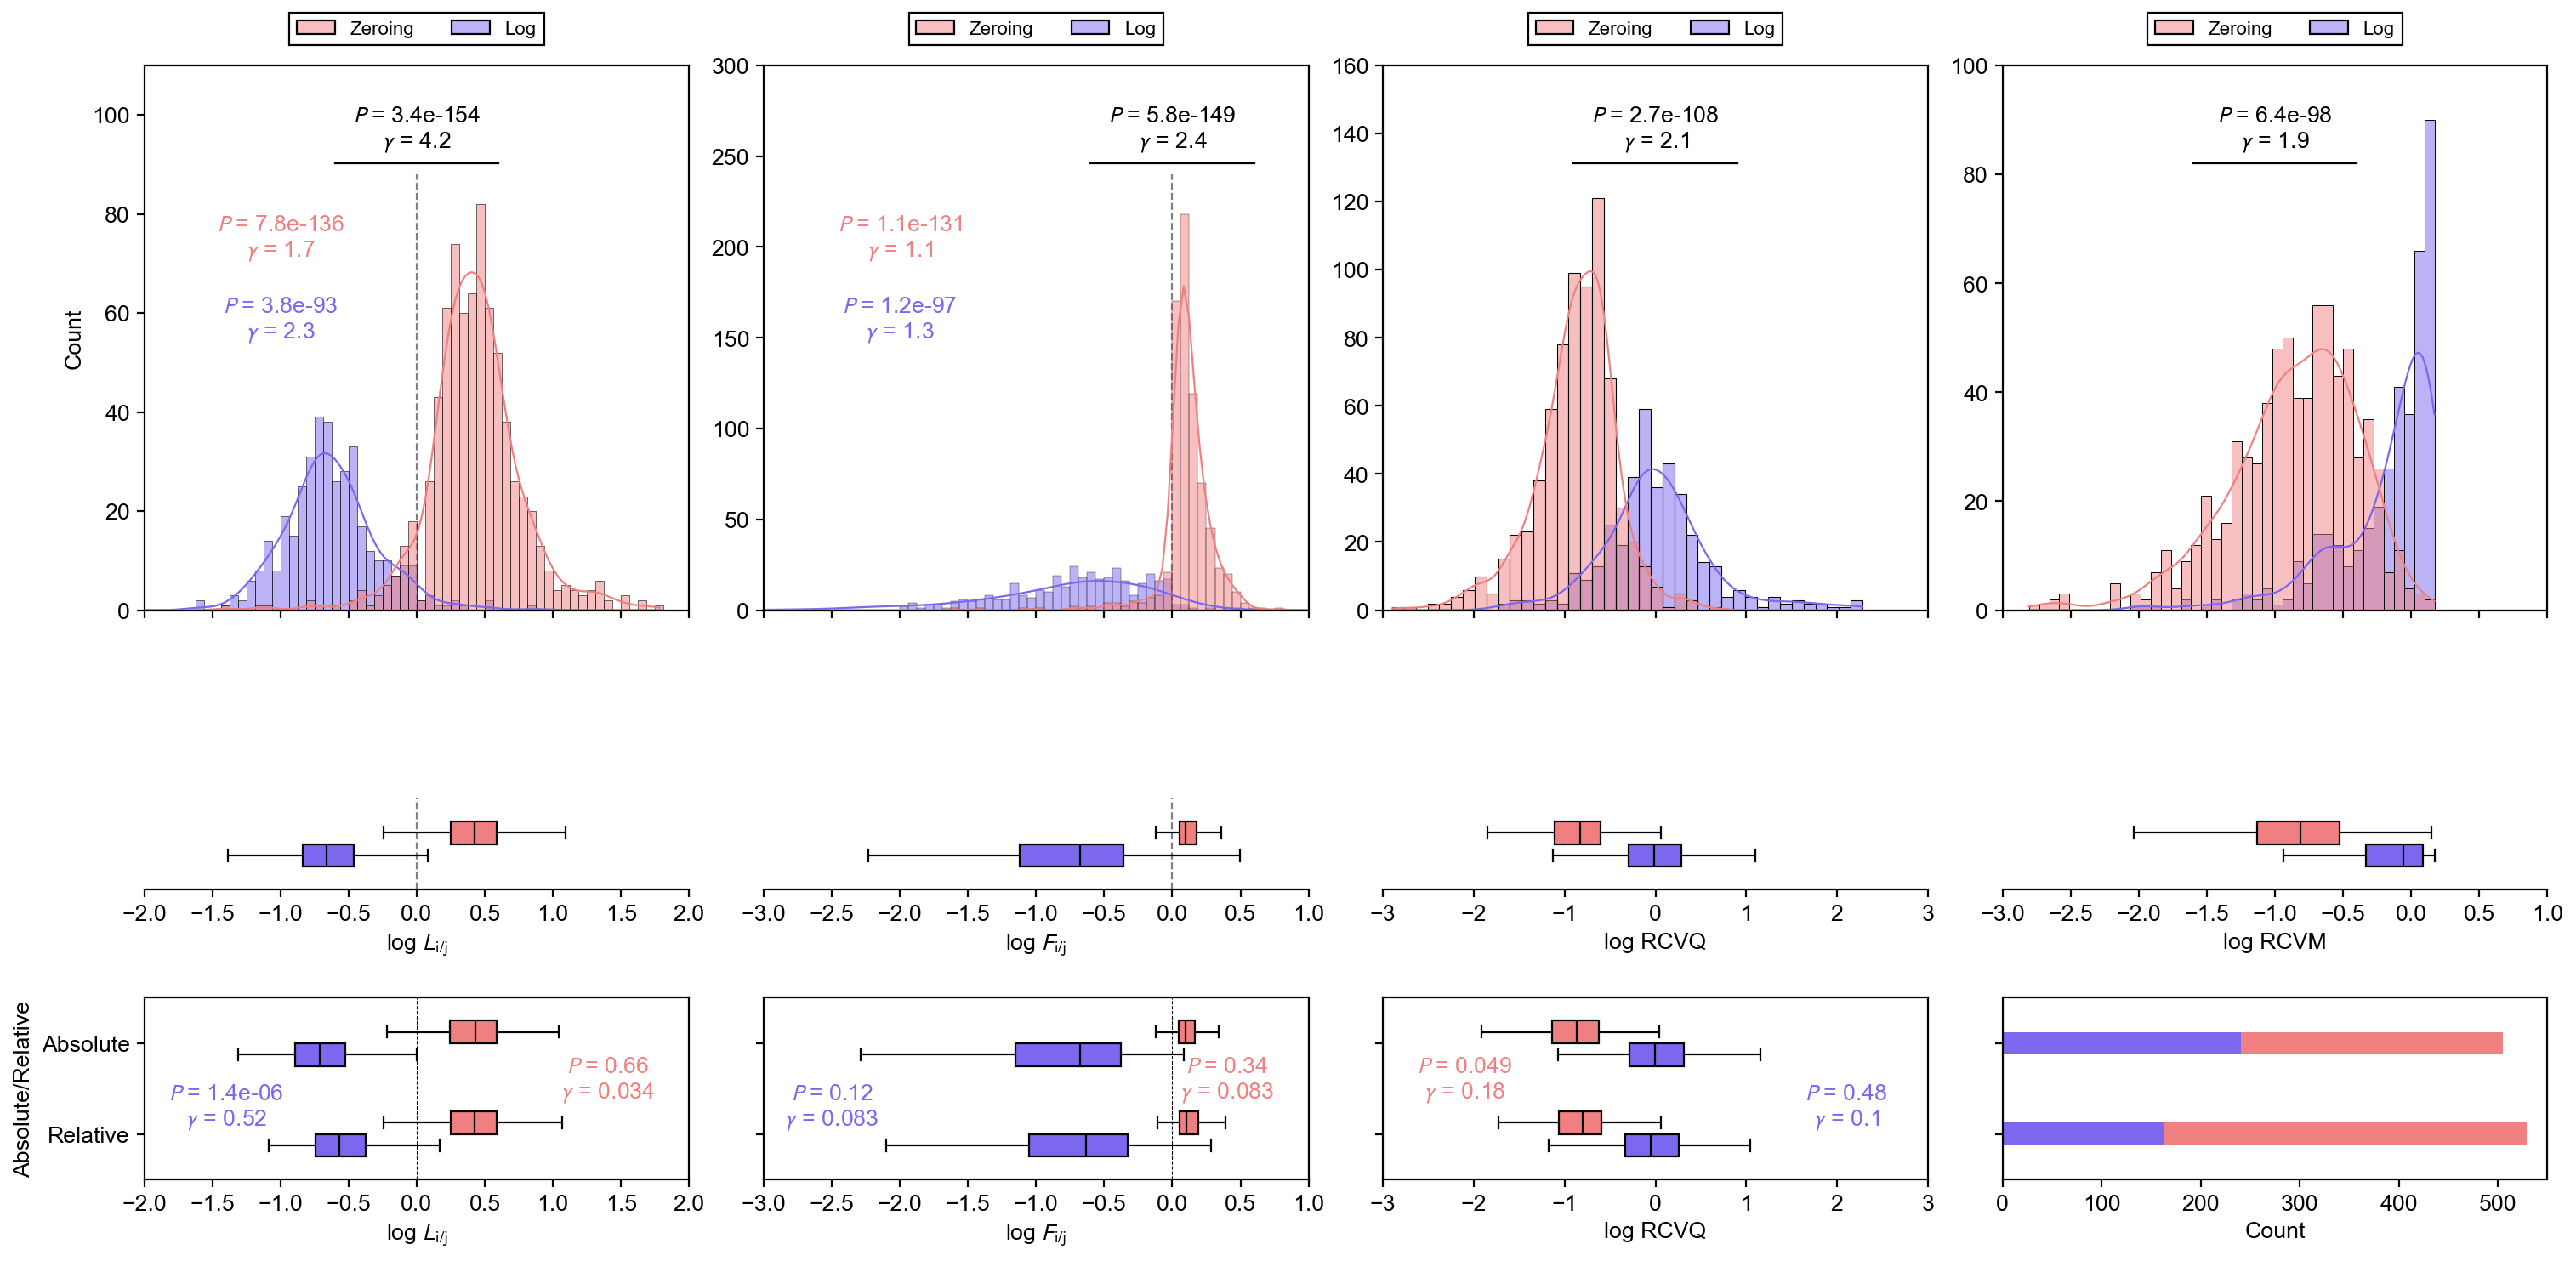

In [4]:
bins = np.arange(-2, 2 + 0.0625, 0.0625)

fig, axs = plt.subplots(3, 4, figsize=(19, 10), height_ratios=[6, 1, 2])
ax_box_rel = axs[1, 0]
ax_hist_rel = axs[0, 0]
ax_box_abs = axs[1, 1]
ax_hist_abs = axs[0, 1]
ax_box_rel_quant = axs[2, 0]
ax_box_abs_quant = axs[2, 1]
ax_box_rcvq_quant = axs[2, 2]
ax_box_rcvm_quant = axs[2, 3]


## subplot 1
property = 'log L_12'
# define visualization domain
xmin = -2
xmax = 2
# eliminate bar-level bias by groupby graphs
plot_df = L_df.groupby(L_df.index).median()
# tag on text properties
plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Mistake', 'Measurand Level I']])
# eliminate graph-level bias by groupby physical quantities
plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.reset_index()
# define zero and log conditions
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')

# print info
print(f"n = {sum(zero_cond)} Zeroing")
print(f"n = {sum(log_cond)} Log")
print(plot_df.shape)

excluded_df = plot_df[(
    ((plot_df[property] > xmax) | (plot_df[property] < xmin))
)]
print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")

# visualization
sns.boxplot(
    plot_df,
    x=property,
    hue='Mistake', 
    ax=ax_box_rel,
    width=0.5,
    legend=False,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
hist = sns.histplot(
    plot_df,
    x=property, 
    hue='Mistake', 
    kde=True,
    bins=bins,
    ax=ax_hist_rel,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
)
ax_box_rel.set_xlim(xmin, xmax)
ax_hist_rel.set_xlim(xmin, xmax)
ax_hist_rel.set_ylim(0, 110)

# configure legend
sns.move_legend(
    hist, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

# label two-sample stats
stat, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
label_stats(
    ax_hist_rel, 
    pvalue, 
    gamma,
)

# label one sample location
one_sample_zero_x = 0.25
one_sample_log_x = one_sample_zero_x
one_sample_zero_y = 0.65
one_sample_y_offset = 0.15
one_sample_log_y = one_sample_zero_y - one_sample_y_offset

# label one-sample stats (zero)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[zero_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    [0]
)
label_stats(
    ax_hist_rel, 
    pvalue, 
    gamma,
    x=one_sample_zero_x,
    y=one_sample_zero_y,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

# label one-sample stats (log)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[log_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[log_cond, property],
    [0]
)
label_stats(
    ax_hist_rel, 
    pvalue, 
    gamma,
    x=one_sample_log_x,
    y=one_sample_log_y,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

## subplot 2
property = 'log F_12'
# define visualization domain
xmin = -3
xmax = 1
# eliminate bar-level bias by groupby graphs
plot_df = util.keep_finite(L_df)
plot_df = plot_df[plot_df['x_1'] > plot_df['x_2']].groupby(plot_df[plot_df['x_1'] > plot_df['x_2']].index).median()
# tag on text properties
plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Mistake', 'Measurand Level I']])  
# eliminate graph-level bias by groupby physical quantities
plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
plot_df = plot_df.reset_index()
# define zero and log conditions
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')

# print info
print(f"n = {sum(zero_cond)} Zeroing")
print(f"n = {sum(log_cond)} Log")
print(plot_df.shape)

excluded_df = plot_df[(
    ((plot_df[property] > xmax) | (plot_df[property] < xmin))
)]
print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")

# visualization
sns.boxplot(
    plot_df,
    x=property,
    hue='Mistake', 
    ax=ax_box_abs,
    width=0.5,
    legend=False,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
hist = sns.histplot(
    plot_df,
    x=property, 
    hue='Mistake', 
    kde=True,
    bins=bins,
    ax=ax_hist_abs,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
)
ax_box_abs.set_xlim(xmin, xmax)
ax_hist_abs.set_xlim(xmin, xmax)
ax_hist_abs.set_ylim(0, 300)

# configure legend
sns.move_legend(
    hist, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

# label two-sample stats
stat, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
label_stats(
    ax_hist_abs, 
    pvalue, 
    gamma,
    x=0.75,
    y=0.85
)

# label one sample location
one_sample_zero_x = 0.25
one_sample_log_x = one_sample_zero_x
one_sample_zero_y = 0.65
one_sample_y_offset = 0.15
one_sample_log_y = one_sample_zero_y - one_sample_y_offset

# label one-sample stats (zero)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[zero_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    [0]
)
label_stats(
    ax_hist_abs, 
    pvalue, 
    gamma,
    x=one_sample_zero_x,
    y=one_sample_zero_y,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

# label one-sample stats (log)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[log_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[log_cond, property],
    [0]
)
label_stats(
    ax_hist_abs, 
    pvalue, 
    gamma,
    x=one_sample_log_x,
    y=one_sample_log_y,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

# common labels by row and col
for i in range(2):
    axs[0, i].set_box_aspect(1)
    axs[0, i].axvline(0, 0, 0.8, color='gray', lw=1, ls='--', zorder=0)
    
    axs[1, i].set_box_aspect(1/6)
    axs[1, i].axis()
    axs[1, i].spines['left'].set_linewidth(0)
    axs[1, i].spines['right'].set_linewidth(0)
    axs[1, i].spines['top'].set_linewidth(0)
    axs[1, i].tick_params(
        axis='y',
        which='both',
        left=False,
    )
    axs[1, i].axvline(0, 0, 1, color='gray', lw=1, ls='--', zorder=0)


# subplot 3, 4
axs[0, 2].set_ylim(0, 160)
axs[0, 3].set_ylim(0, 100)
axs[0, 2].set_xlim(-3, 3)
axs[0, 3].set_xlim(-3, 1)

property_list = [
    'RCVQ',
    'RCVM',
]
for i, col_i in enumerate(range(2, 2+len(property_list))):
    property = property_list[i]
    log_property = f'log {property}'
    #
    xmin, xmax = axs[0, col_i].get_xlim()
    # bins = np.arange(xmin, xmax + 0.0625, 0.0625)
    plot_df = util.keep_finite(cv_df)
    # tag on text properties
    plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Measurand Level I']])  
    # eliminate graph-level bias by groupby physical quantities
    plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
    plot_df = plot_df.reset_index()
    # define zero and log conditions
    zero_cond = (plot_df['Mistake'] == 'zero')
    log_cond = (plot_df['Mistake'] == 'log')
    # print info
    print(log_property)
    print(f"n = {sum(zero_cond)} Zeroing")
    print(f"n = {sum(log_cond)} Log")
    print(plot_df.shape)
    
    excluded_df = plot_df[(
        ((plot_df[log_property] > xmax) | (plot_df[log_property] < xmin))
    )]
    print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")
    print()
    
    ## first row
    hist = sns.histplot(
        plot_df[
            (plot_df[log_property] >= xmin)
            & (plot_df[log_property] <= xmax)
        ],
        x=log_property,
        hue='Mistake',
        bins=40,
        kde=True,
        hue_order=['zero', 'log'],
        palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
        ax=axs[0, col_i],
    )
    # configure legend
    sns.move_legend(
        hist, 
        loc='lower center', 
        **dict(
            bbox_to_anchor=(0.5, 1.02),
            title='',
            labels=[ZERO_LABEL, LOG_LABEL],
            ncol=2,
        )
    )

    # second row
    box = sns.boxplot(
        plot_df,
        x=log_property,
        hue='Mistake',
        hue_order=['zero', 'log'],
        palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
        width=0.5,
        legend=False,
        showfliers=False,
        saturation=1,
        linecolor='k',
        ax=axs[1, col_i],
    )
    
    # label stats
    stat, pvalue = scipy.stats.mannwhitneyu(
        plot_df.loc[zero_cond, log_property],
        plot_df.loc[log_cond, log_property],
    )
    gamma = util.get_gamma(
        plot_df.loc[zero_cond, log_property],
        plot_df.loc[log_cond, log_property],
    )
    label_stats(
        axs[0, col_i], 
        pvalue, 
        gamma,
    )

for col_i in range(2, 2+len(property_list)):
    axs[0, col_i].set_box_aspect(1)
    axs[1, col_i].set_box_aspect(1/6)
    axs[1, col_i].spines['left'].set_linewidth(0)
    axs[1, col_i].spines['right'].set_linewidth(0)
    axs[1, col_i].spines['top'].set_linewidth(0)
    axs[1, col_i].tick_params(
        axis='y',
        which='both',
        left=False,
    )

for i in range(1, 4):
    axs[0, i].set_ylabel('')

axs[1, 0].set_xlabel('log $L_{\mathrm{i/j}}$')
axs[1, 1].set_xlabel('log $F_{\mathrm{i/j}}$')

#######################################
#######################################
#######################################
#######################################
## subplot 1
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']])
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']).median().reset_index()
print(plot_df.shape)

property = 'log L_12'
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')
abs_cond = (plot_df['Absolute/Relative'] == 'Absolute')
rel_cond = (plot_df['Absolute/Relative'] == 'Relative')
stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
print(f'zero: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    ax_box_rel_quant, 
    pvalue, 
    gamma,
    x=0.85,
    y=0.45,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
print(f'log: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    ax_box_rel_quant, 
    pvalue, 
    gamma,
    x=0.15,
    y=0.3,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

box = sns.boxplot(
    plot_df,
    x='log L_12',
    y='Absolute/Relative',
    hue='Mistake', 
    ax=ax_box_rel_quant,
    width=0.5,
    showfliers=False,
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
    legend=False,
)
## subplot 2
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']])
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']).median().reset_index()
print(plot_df.shape)

property = 'log F_12'
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')
abs_cond = (plot_df['Absolute/Relative'] == 'Absolute')
rel_cond = (plot_df['Absolute/Relative'] == 'Relative')
stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
print(f'zero: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    ax_box_abs_quant, 
    pvalue, 
    gamma,
    x=0.85,
    y=0.45,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
print(f'log: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    ax_box_abs_quant, 
    pvalue, 
    gamma,
    x=0.125,
    y=0.3,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

box = sns.boxplot(
    plot_df,
    x='log F_12', 
    y='Absolute/Relative',
    hue='Mistake',
    ax=ax_box_abs_quant,
    width=0.5,
    showfliers=False,
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
    legend=False,
)

## subplot 3
plot_df = util.keep_finite(cv_df)
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Measurand Level I']])
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
plot_df = plot_df.reset_index()
print(plot_df.shape)

property = 'log RCVQ'
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')
abs_cond = (plot_df['Absolute/Relative'] == 'Absolute')
rel_cond = (plot_df['Absolute/Relative'] == 'Relative')
stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
print(f'zero: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    ax_box_rcvq_quant, 
    pvalue, 
    gamma,
    x=0.15,
    y=0.45,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
print(f'log: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    ax_box_rcvq_quant, 
    pvalue, 
    gamma,
    x=0.85,
    y=0.3,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

box = sns.boxplot(
    plot_df,
    x=property, 
    y='Absolute/Relative',
    hue='Mistake',
    ax=ax_box_rcvq_quant,
    width=0.5,
    showfliers=False,
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
    legend=False,
)

## subplot 4
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index()
df = df.groupby(['Absolute/Relative', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Absolute/Relative').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.cumsum(axis=1).stack().reset_index(name='Count')
plot_df = df.copy()

bar = sns.barplot(
    data=plot_df,
    x='Count',
    y='Absolute/Relative',
    hue='Mistake',
    orient='h',
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    dodge=False,
    saturation=1,
    width=0.25,
    ax=ax_box_rcvm_quant,
    legend=False,
)

for ax in [ax_box_rel_quant, ax_box_abs_quant]:
    ax.axvline(0, color='k', ls='--', lw=0.5, zorder=999)
for ax in [ax_box_rel_quant, ax_box_abs_quant, ax_box_rcvq_quant, ax_box_rcvm_quant]:
    ax.set_box_aspect(1/3)
for ax in [ax_box_abs_quant, ax_box_rcvq_quant, ax_box_rcvm_quant]:
    ax.set_ylabel('')
    ax.set_yticklabels('')

for ax in [ax_hist_rel, ax_box_rel, ax_box_rel_quant]:
    ax.set_xlim(-2, 2)
for ax in [ax_hist_abs, ax_box_abs, ax_box_abs_quant]:
    ax.set_xlim(-3, 1)
for ax in [axs[0, 2], axs[1, 2], ax_box_rcvq_quant]:
    ax.set_xlim(-3, 3)
for ax in [axs[0, 3], axs[1, 3]]:
    ax.set_xlim(-3, 1)
for ax in [ax_hist_rel, ax_hist_abs, axs[0, 2], axs[0, 3]]:
    ax.set_xlabel('')
    ax.set_xticklabels('')


ax_box_rel_quant.set_xlim(-2, 2)
ax_box_abs_quant.set_xlim(-3, 1)
ax_box_rcvq_quant.set_xlim(-3, 3)
ax_box_rcvm_quant.set_xlim(0, 550)

ax_box_rel_quant.set_xlabel('log $L_{\mathrm{i/j}}$')
ax_box_abs_quant.set_xlabel('log $F_{\mathrm{i/j}}$')

plt.tight_layout(pad=1)
fig.savefig(get_figure_filepath(data_distortion_metrics_main_filename))
# post processing: crop to three images with same width and make the blank space smaller

### 4 Data distortion metrics for article

In [5]:
plt.rcParams.update({
    'font.family': 'Arial',  # Times New Roman, Calibri
    'font.weight': 'normal',
    'mathtext.fontset': 'stixsans',
    'font.size': 8,

    'lines.linewidth': 0.5,

    'axes.linewidth': 0.5,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'axes.titleweight': 'normal',
    'axes.titlesize': 8,
    'axes.labelweight': 'normal',

    'xtick.major.size': 2,
    'xtick.major.width': 0.5,
    'ytick.major.size': 2,
    'ytick.major.width': 0.5,

    'figure.dpi': 80,
    'savefig.dpi': 600,

    'legend.framealpha': 0,
    'legend.edgecolor': 'black',
    'legend.fancybox': False,
    'legend.fontsize': 8,

    'animation.html': 'html5',
    'pdf.fonttype': 42,
})

In [6]:
def label_stats(ax, pvalue, gamma, x=0.5, y=0.85, color='k', two_sample=True):
    line_y_offset = 0.03
    line_x_offset = 0.15
    if pvalue < 0.001:
        ax.text(
            x, 
            y,
            '$\it{P}$ = ' + f'{pvalue:.1e}' + '\n$\gamma$ = ' + f'{gamma:.2}',
            ha='center',
            transform=ax.transAxes,
            color=color,
            fontsize=8,
        )
    else:
        ax.text(
            x, 
            y,
            '$\it{P}$ = ' + f'{pvalue:.2}' + '\n$\gamma$ = ' + f'{gamma:.2}',
            ha='center',
            transform=ax.transAxes,
            color=color,
            fontsize=8,
        )
    if two_sample:
        ax.axhline(
            (y - line_y_offset) * ax.get_ylim()[1],
            x - line_x_offset, 
            x + line_x_offset,
            color=color,
            lw=0.5,
        )

n = 747 Zeroing
n = 387 Log
(1134, 18)
Visualization excluded outlier 2/1134 = 0.001763668430335097
n = 747 Zeroing
n = 387 Log
(1134, 18)
Visualization excluded outlier 7/1134 = 0.006172839506172839
log RCVQ
n = 732 Zeroing
n = 390 Log
(1122, 10)
Visualization excluded outlier 8/1122 = 0.0071301247771836

(1135, 19)
(1135, 19)


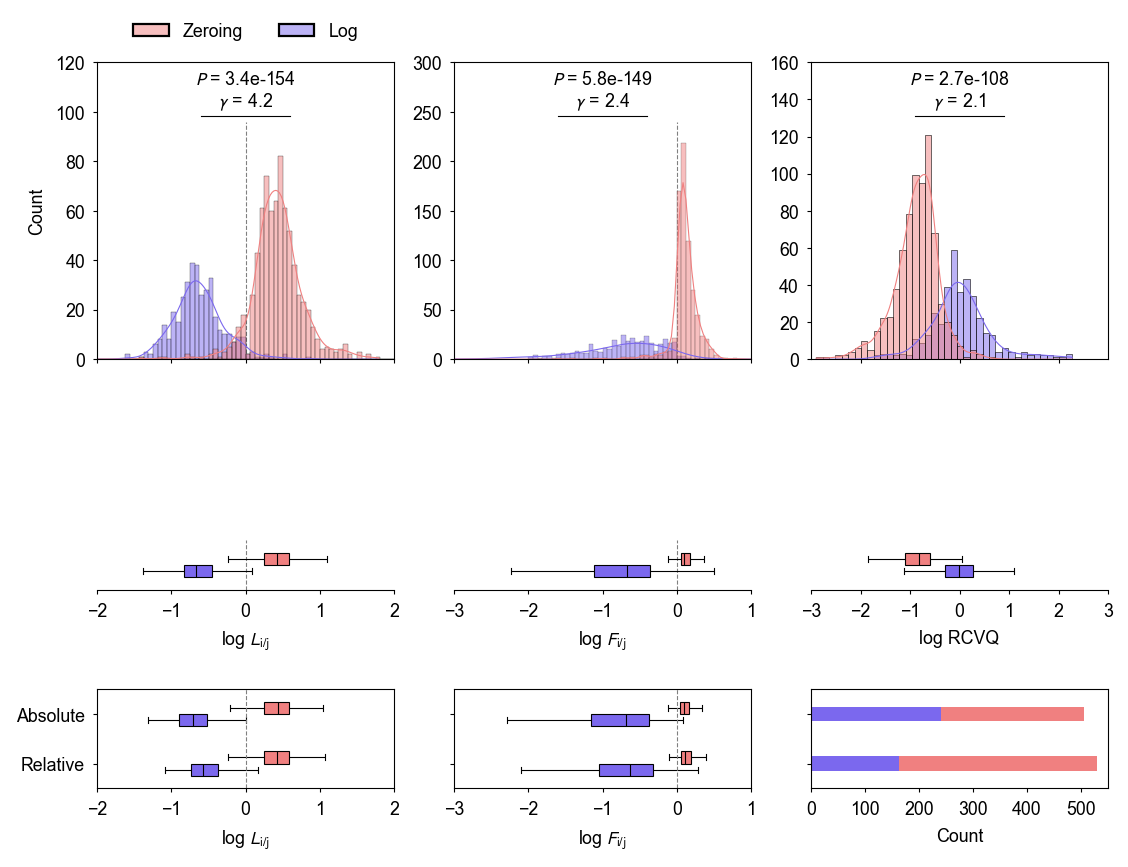

In [7]:
bins = np.arange(-2, 2 + 0.0625, 0.0625)

fig, axs = plt.subplots(3, 3, figsize=(7.08, 6), height_ratios=[6, 1, 2])
ax_box_rel = axs[1, 0]
ax_hist_rel = axs[0, 0]
ax_box_abs = axs[1, 1]
ax_hist_abs = axs[0, 1]
ax_box_rel_quant = axs[2, 0]
ax_box_abs_quant = axs[2, 1]
ax_box_rcvq_quant = axs[2, 2]


## subplot 1
property = 'log L_12'
# define visualization domain
xmin = -2
xmax = 2
# eliminate bar-level bias by groupby graphs
plot_df = L_df.groupby(L_df.index).median()
# tag on text properties
plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Mistake', 'Measurand Level I']])
# eliminate graph-level bias by groupby physical quantities
plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.reset_index()
# define zero and log conditions
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')

# print info
print(f"n = {sum(zero_cond)} Zeroing")
print(f"n = {sum(log_cond)} Log")
print(plot_df.shape)

excluded_df = plot_df[(
    ((plot_df[property] > xmax) | (plot_df[property] < xmin))
)]
print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")

# visualization
sns.boxplot(
    plot_df,
    x=property,
    hue='Mistake', 
    ax=ax_box_rel,
    width=0.5,
    legend=False,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
    linewidth=0.5,
)
hist = sns.histplot(
    plot_df,
    x=property, 
    hue='Mistake', 
    kde=True,
    bins=bins,
    ax=ax_hist_rel,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    legend=True,
)
ax_box_rel.set_xlim(xmin, xmax)
ax_hist_rel.set_xlim(xmin, xmax)
ax_hist_rel.set_ylim(0, 120)

# configure legend
sns.move_legend(
    hist, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

# label two-sample stats
stat, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
label_stats(
    ax_hist_rel, 
    pvalue, 
    gamma,
)

## subplot 2
property = 'log F_12'
# define visualization domain
xmin = -3
xmax = 1
# eliminate bar-level bias by groupby graphs
plot_df = util.keep_finite(L_df)
plot_df = plot_df[plot_df['x_1'] > plot_df['x_2']].groupby(plot_df[plot_df['x_1'] > plot_df['x_2']].index).median()
# tag on text properties
plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Mistake', 'Measurand Level I']])  
# eliminate graph-level bias by groupby physical quantities
plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
plot_df = plot_df.reset_index()
# define zero and log conditions
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')

# print info
print(f"n = {sum(zero_cond)} Zeroing")
print(f"n = {sum(log_cond)} Log")
print(plot_df.shape)

excluded_df = plot_df[(
    ((plot_df[property] > xmax) | (plot_df[property] < xmin))
)]
print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")

# visualization
sns.boxplot(
    plot_df,
    x=property,
    hue='Mistake', 
    ax=ax_box_abs,
    width=0.5,
    legend=False,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
    linewidth=0.5,
)
hist = sns.histplot(
    plot_df,
    x=property, 
    hue='Mistake', 
    kde=True,
    bins=bins,
    ax=ax_hist_abs,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    legend=False,
)
ax_box_abs.set_xlim(xmin, xmax)
ax_hist_abs.set_xlim(xmin, xmax)
ax_hist_abs.set_ylim(0, 300)


# label two-sample stats
stat, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
label_stats(
    ax_hist_abs, 
    pvalue, 
    gamma,
    x=0.5,
    y=0.85
)

# common labels by row and col
for i in range(2):
    axs[0, i].set_box_aspect(1)
    axs[0, i].axvline(0, 0, 0.8, color='gray', lw=0.5, ls='--', zorder=0)
    
    axs[1, i].set_box_aspect(1/6)
    axs[1, i].axis()
    axs[1, i].spines['left'].set_linewidth(0)
    axs[1, i].spines['right'].set_linewidth(0)
    axs[1, i].spines['top'].set_linewidth(0)
    axs[1, i].tick_params(
        axis='y',
        which='both',
        left=False,
    )
    axs[1, i].axvline(0, 0, 1, color='gray', lw=0.5, ls='--', zorder=0)


# subplot 3, 4
axs[0, 2].set_ylim(0, 160)
# axs[0, 3].set_ylim(0, 100)
axs[0, 2].set_xlim(-3, 3)
# axs[0, 3].set_xlim(-3, 1)

property_list = [
    'RCVQ',
    # 'RCVM',
]
for i, col_i in enumerate(range(2, 2+len(property_list))):
    property = property_list[i]
    log_property = f'log {property}'
    #
    xmin, xmax = axs[0, col_i].get_xlim()
    # bins = np.arange(xmin, xmax + 0.0625, 0.0625)
    plot_df = util.keep_finite(cv_df)
    # tag on text properties
    plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Measurand Level I']])  
    # eliminate graph-level bias by groupby physical quantities
    plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
    plot_df = plot_df.reset_index()
    # define zero and log conditions
    zero_cond = (plot_df['Mistake'] == 'zero')
    log_cond = (plot_df['Mistake'] == 'log')
    # print info
    print(log_property)
    print(f"n = {sum(zero_cond)} Zeroing")
    print(f"n = {sum(log_cond)} Log")
    print(plot_df.shape)
    
    excluded_df = plot_df[(
        ((plot_df[log_property] > xmax) | (plot_df[log_property] < xmin))
    )]
    print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")
    print()
    
    ## first row
    hist = sns.histplot(
        plot_df[
            (plot_df[log_property] >= xmin)
            & (plot_df[log_property] <= xmax)
        ],
        x=log_property,
        hue='Mistake',
        bins=40,
        kde=True,
        hue_order=['zero', 'log'],
        palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
        ax=axs[0, col_i],
        legend=False,
    )
    # # configure legend
    # sns.move_legend(
    #     hist, 
    #     loc='lower center', 
    #     **dict(
    #         bbox_to_anchor=(0.5, 1.02),
    #         title='',
    #         labels=[ZERO_LABEL, LOG_LABEL],
    #         ncol=2,
    #     )
    # )

    # second row
    box = sns.boxplot(
        plot_df,
        x=log_property,
        hue='Mistake',
        hue_order=['zero', 'log'],
        palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
        width=0.5,
        legend=False,
        showfliers=False,
        saturation=1,
        linecolor='k',
        ax=axs[1, col_i],
        linewidth=0.5,
    )
    
    # label stats
    stat, pvalue = scipy.stats.mannwhitneyu(
        plot_df.loc[zero_cond, log_property],
        plot_df.loc[log_cond, log_property],
    )
    gamma = util.get_gamma(
        plot_df.loc[zero_cond, log_property],
        plot_df.loc[log_cond, log_property],
    )
    label_stats(
        axs[0, col_i], 
        pvalue, 
        gamma,
    )

for col_i in range(2, 2+len(property_list)):
    axs[0, col_i].set_box_aspect(1)
    axs[1, col_i].set_box_aspect(1/6)
    axs[1, col_i].spines['left'].set_linewidth(0)
    axs[1, col_i].spines['right'].set_linewidth(0)
    axs[1, col_i].spines['top'].set_linewidth(0)
    axs[1, col_i].tick_params(
        axis='y',
        which='both',
        left=False,
    )

# for i in range(1, 4):
for i in range(1, 3):
    axs[0, i].set_ylabel('')

axs[1, 0].set_xlabel('log $L_{\mathrm{i/j}}$')
axs[1, 1].set_xlabel('log $F_{\mathrm{i/j}}$')

#######################################
#######################################
#######################################
#######################################
## subplot 1
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']])
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']).median().reset_index()
print(plot_df.shape)

property = 'log L_12'
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')
abs_cond = (plot_df['Absolute/Relative'] == 'Absolute')
rel_cond = (plot_df['Absolute/Relative'] == 'Relative')

box = sns.boxplot(
    plot_df,
    x='log L_12',
    y='Absolute/Relative',
    hue='Mistake', 
    ax=ax_box_rel_quant,
    width=0.5,
    showfliers=False,
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
    legend=False,
    linewidth=0.5,
)

## subplot 2
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']])
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']).median().reset_index()
print(plot_df.shape)

property = 'log F_12'
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')
abs_cond = (plot_df['Absolute/Relative'] == 'Absolute')
rel_cond = (plot_df['Absolute/Relative'] == 'Relative')

box = sns.boxplot(
    plot_df,
    x='log F_12', 
    y='Absolute/Relative',
    hue='Mistake',
    ax=ax_box_abs_quant,
    width=0.5,
    showfliers=False,
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
    legend=False,
    linewidth=0.5,
)

## subplot 3
# plot_df = util.keep_finite(cv_df)
# plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Measurand Level I']])
# plot_df = util.keep_finite(plot_df)
# plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
# plot_df = plot_df.reset_index()
# print(plot_df.shape)

# property = 'log RCVQ'
# zero_cond = (plot_df['Mistake'] == 'zero')
# log_cond = (plot_df['Mistake'] == 'log')
# abs_cond = (plot_df['Absolute/Relative'] == 'Absolute')
# rel_cond = (plot_df['Absolute/Relative'] == 'Relative')

# box = sns.boxplot(
#     plot_df,
#     x=property, 
#     y='Absolute/Relative',
#     hue='Mistake',
#     ax=ax_box_rcvq_quant,
#     width=0.5,
#     showfliers=False,
#     order=['Absolute', 'Relative'],
#     hue_order=['zero', 'log'],
#     palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
#     saturation=1,
#     linecolor='k',
#     legend=False,
#     linewidth=0.5,
# )

# subplot 4
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index()
df = df.groupby(['Absolute/Relative', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Absolute/Relative').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.cumsum(axis=1).stack().reset_index(name='Count')
plot_df = df.copy()

bar = sns.barplot(
    data=plot_df,
    x='Count',
    y='Absolute/Relative',
    hue='Mistake',
    orient='h',
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    dodge=False,
    saturation=1,
    width=0.3,
    # ax=ax_box_rcvm_quant,
    ax=axs[2, 2],
    legend=False,
    lw=0.5,
)

ax_hist_rcvq = axs[0, 2]
# ax_hist_rcvm = axs[0, 3]
ax_box_rcvq = axs[1, 2]
# ax_box_rcvm = axs[1, 3]

for ax in [ax_box_rel_quant, ax_box_abs_quant]:
    ax.axvline(0, color='gray', ls='--', lw=0.5, zorder=999)
for ax in [ax_box_rel_quant, ax_box_abs_quant, ax_box_rcvq_quant]:
    ax.set_box_aspect(1/3)
for ax in [ax_box_abs_quant, ax_box_rcvq_quant]:
    ax.set_ylabel('')
    ax.set_yticklabels('')

for ax in [ax_hist_rel, ax_box_rel, ax_box_rel_quant]:
    ax.set_xlim(-2, 2)
for ax in [ax_hist_abs, ax_box_abs, ax_box_abs_quant]:
    ax.set_xlim(-3, 1)
for ax in [ax_hist_rcvq, ax_box_rcvq, ax_box_rcvq_quant]:
    ax.set_xlim(-3, 3)
for ax in [ax_hist_rel, ax_hist_abs, ax_hist_rcvq]:
    ax.set_xlabel('')
    ax.set_xticklabels('')

ax_box_rel.set_xticks([-2, -1, 0, 1, 2])
ax_box_rel_quant.set_xticks([-2, -1, 0, 1, 2])
ax_box_abs.set_xticks([-3, -2, -1, 0, 1])
ax_box_abs_quant.set_xticks([-3, -2, -1, 0, 1])
ax_box_rcvq.set_xticks([-3, -2, -1, 0, 1, 2, 3])
ax_box_rcvq_quant.set_xticks([-3, -2, -1, 0, 1, 2, 3])
axs[2, 2].set_xticks([0, 100, 200, 300, 400, 500])

ax_box_rel_quant.set_xlim(-2, 2)
ax_box_abs_quant.set_xlim(-3, 1)
ax_box_rcvq_quant.set_xlim(-3, 3)
axs[2, 2].set_xlim(0, 550)

ax_box_rel_quant.set_ylabel('')
ax_box_rel_quant.set_xlabel('log $L_{\mathrm{i/j}}$')
ax_box_abs_quant.set_xlabel('log $F_{\mathrm{i/j}}$')

plt.tight_layout(pad=1)
fig.savefig(get_figure_filepath(data_distortion_metrics_main_filename, loc=FIG_ARTICLE_SUBPANELS_PATH))
# post processing: crop to three images with same width and make the blank space smaller

### Metrics vs. Measurand, grouped by mistake types

#### Measurand Level II

In [8]:
plt.rcParams.update({
    'font.family': 'Arial',  # Times New Roman, Calibri
    'font.weight': 'normal',
    'mathtext.fontset': 'stixsans',
    'font.size': 8,

    'lines.linewidth': 0.5,

    'axes.linewidth': 0.5,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'axes.titleweight': 'normal',
    'axes.titlesize': 8,
    'axes.labelweight': 'normal',

    'xtick.major.size': 2,
    'xtick.major.width': 0.5,
    'ytick.major.size': 2,
    'ytick.major.width': 0.5,

    'figure.dpi': 80,
    'savefig.dpi': 600,

    'legend.framealpha': 0,
    'legend.edgecolor': 'black',
    'legend.fancybox': False,
    'legend.fontsize': 8,

    'animation.html': 'html5',
    'pdf.fonttype': 42,
})

In [9]:
# order by the 5th subplot
# in ascending fraction of zeroing (descending fraction of log)
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Measurand Level II']).count().iloc[:, 0].reset_index()
df = df.groupby(['Measurand Level II', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Measurand Level II').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.div(df.sum(axis=1), axis=0) * 100
order = df.sort_values('zero', ascending=True).index

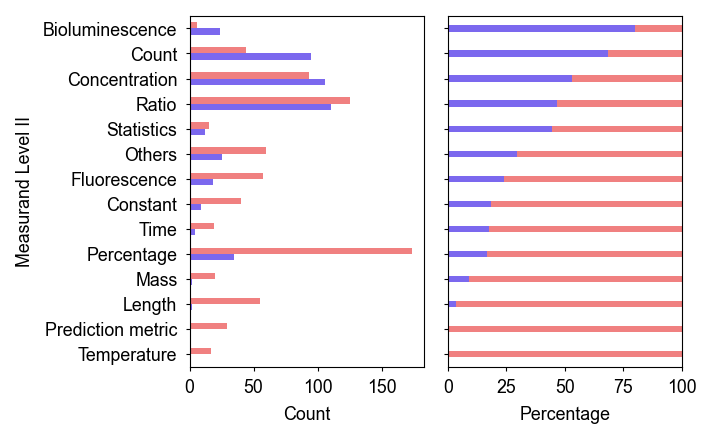

In [10]:
row = 1
col = 2
scale = 3
fig, axs = plt.subplots(row, col, figsize=(4.5, 5), sharey=True)

## subplot 4
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Measurand Level II']).count().iloc[:, 0].reset_index()
df = df.groupby(['Measurand Level II', 'Mistake']).count().iloc[:, 0]
df.name = 'Count'
df = df.to_frame().reset_index()
plot_df = df.copy()

bar = sns.barplot(
    data=plot_df,
    x='Count',
    y='Measurand Level II',
    hue='Mistake',
    orient='h',
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    width=0.5,
    ax=axs[0],
    legend=False,
)

## subplot 5
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Measurand Level II']).count().iloc[:, 0].reset_index()
df = df.groupby(['Measurand Level II', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Measurand Level II').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.div(df.sum(axis=1), axis=0) * 100
df = df.cumsum(axis=1).stack().reset_index(name='Percentage')
plot_df = df.copy()

bar = sns.barplot(
    plot_df,
    x='Percentage',
    y='Measurand Level II',
    hue='Mistake',
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    dodge=False,
    saturation=1,
    width=0.25,
    ax=axs[1],
    legend=False,
)

for i in range(2):
    axs[i].set_box_aspect(1.5)

axs[1].set_xlim(0, 100)


plt.tight_layout()
fig.savefig(get_figure_filepath(data_distortion_metrics_measurand_ii_filename, loc=FIG_POSTER_PATH))

#### Journal

In [11]:
# order by the 5th subplot
# in ascending fraction of zeroing (descending fraction of log)
df = bar_annot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).count().iloc[:, 0].reset_index()
df = df.groupby(['Journal', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Journal').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.div(df.sum(axis=1), axis=0) * 100
order = df.sort_values('zero', ascending=True).index

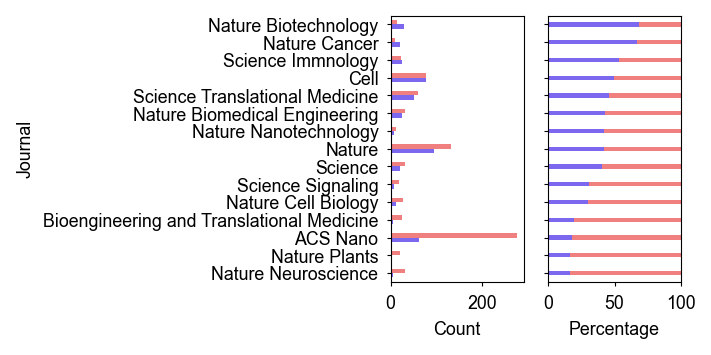

In [12]:
row = 1
col = 2
scale = 3
fig, axs = plt.subplots(row, col, figsize=(4.5, 5), sharey=True)

## subplot 1
df = bar_annot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).count().iloc[:, 0].reset_index()
df = df.groupby(['Journal', 'Mistake']).count().iloc[:, 0]
df.name = 'Count'
df = df.to_frame().reset_index()
plot_df = df.copy()

bar = sns.barplot(
    data=plot_df,
    x='Count',
    y='Journal',
    hue='Mistake',
    orient='h',
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    width=0.5,
    legend=False,
    ax=axs[0],
)

## subplot 2
df = bar_annot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).count().iloc[:, 0].reset_index()
df = df.groupby(['Journal', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Journal').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.div(df.sum(axis=1), axis=0) * 100
df = df.cumsum(axis=1).stack().reset_index(name='Percentage')
plot_df = df.copy()

bar = sns.barplot(
    plot_df,
    x='Percentage',
    y='Journal',
    hue='Mistake',
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    dodge=False,
    saturation=1,
    width=0.25,
    legend=False,
    ax=axs[1],
)

for i in range(2):
    axs[i].set_box_aspect(2)
    
axs[1].set_xlim(0, 100)

axs[0].set_yticklabels([
    'Nature Biotechnology',
    'Nature Cancer',
    'Science Immnology',
    'Cell',
    'Science Translational Medicine',
    'Nature Biomedical Engineering',
    'Nature Nanotechnology',
    'Nature',
    'Science',
    'Science Signaling',
    'Nature Cell Biology',
    'Bioengineering and Translational Medicine',
    'ACS Nano',
    'Nature Plants',
    'Nature Neuroscience',
])

plt.tight_layout()
fig.savefig(get_figure_filepath(data_distortion_metrics_journals_filename, loc=FIG_POSTER_PATH))